# Seleccion de variables mediante la Entropia de Shannon
## 1. Introduccion
<p>No siempre es obvia la cantidad de información que aporta un atributo al resultado de la variable objetivo. Aquí vamos a ver un método relativamente sencillo de medirlo.</p>
<p>Es un muy buen método para obtener relación entre variables independientes con respecto a la variable objetivo. Usa conceptos de Entropía de termodinámica aplicada a la información (Shannon, 1948). Puede obtenerse un ranking ordenado de las variables según cuán fuerte es su aporte de información hacia la variable objetivo. Y se usa como un metodo alternativo al calculo de las correlaciones estadisticas.</p>
<p>En este trabajo se presenta un ejemplo del uso de la entropia de Shannon para la selección de variables a partir del dataset público del hundimiento del Titanic: titanic.csv basado en la informacion presentada en el sitio del Laberinto de Falken: https://www.ellaberintodefalken.com/2018/09/seleccion-atributos-relevantes-entropia-shannon.html</p>

### Carga de Librerias y Datos

In [51]:
# Librerias
import pandas as pd
import requests
import numpy as np
import math
import os

# Datos
link="https://rudeboybert.github.io/SDS220/static/PS/titanic.csv"
data=pd.read_csv(link)

# Acerca del Dataset:
print("tamaño del dataset:",data.shape)

# Eliminaremos la variable 'passengerId' y 'Name'
columnas=data.columns.tolist()
print(columnas)
columnasAeliminar=["passenger_number"]
df=data.drop(columnasAeliminar, axis=1)
print("Eliminacion de columna 'passenger_number':")
print(df)

tamaño del dataset: (2201, 5)
['passenger_number', 'Class', 'Sex', 'Age', 'Survived']
Eliminacion de columna 'passenger_number':
     Class   Sex    Age Survived
0      2nd  Male  Adult       No
1      3rd  Male  Child       No
2      3rd  Male  Adult       No
3     Crew  Male  Adult       No
4     Crew  Male  Adult       No
...    ...   ...    ...      ...
2196  Crew  Male  Adult       No
2197  Crew  Male  Adult      Yes
2198   3rd  Male  Adult       No
2199  Crew  Male  Adult       No
2200   1st  Male  Adult       No

[2201 rows x 4 columns]


## 2. Las variables
### 2.1. Variables

In [52]:
# Las variables
print("Variables=",df.columns.tolist())
# Valores de cada variable:
for i in range(df.shape[1]):
    print("valores de ",df.columns.tolist()[i],"=",set(list(df.iloc[:,i])))

Variables= ['Class', 'Sex', 'Age', 'Survived']
valores de  Class = {'3rd', 'Crew', '1st', '2nd'}
valores de  Sex = {'Male', 'Female'}
valores de  Age = {'Adult', 'Child'}
valores de  Survived = {'No', 'Yes'}


In [53]:
# Binarizaremos la variable objetivo "survived" (reemplazar 'si' / 'no' por 1 / 0):
df["Survived"] = df["Survived"].replace({ "Yes": 1, "No": 0 })

### 2.2. Variables dependientes e independientes

In [54]:
cols=df.columns.tolist()
vars_indep=cols[:len(cols)-1]
vars_target=cols[len(cols)-1]
# Variables independientes:
print("vars_indep=",vars_indep)
# Variables targets:
print("vars_target=",vars_target)

vars_indep= ['Class', 'Sex', 'Age']
vars_target= Survived


## 3. La entropia de Shannon
### 3.1. Definición de Entropia
La entropía es una medida del desorden de un conjunto datos, y se define como:
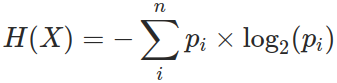
Donde pi es la probabilidad relativa de aparición de la propiedad i en el conjunto de datos. Por ejemplo, p1 podría ser la probabilidad de tener cáncer de pulmón y p2 la probabilidad de no tenerlo.

### 3.2. Cálculo de la entropía
Lo que nos dice este valor es la medida de desorden de la variable explicada con un valor que va de 0 a 1. Un valor de 0 indica orden total, o lo que es lo mismo, o todos sobrevivieron o todos murieron, pero todos los valores son iguales. Cuanto más cerca esté de 1, mayor desorden. Un valor 1 querría decir que el 50% de pasajeros murieron y el otro 50% sobrevivió (hay que tener en cuenta que la entropía no es una función lineal).<br>
Fuente: https://www.ellaberintodefalken.com/2018/09/seleccion-atributos-relevantes-entropia-shannon.html

In [55]:
def calcularEntropia(data,variable):
    #serie_numerica de la variable = pd.Series(lista_numerica)
    serie_Variable = data.iloc[:,variable]
    # Calcular frecuencia de cada valor
    frecuencia = serie_Variable.value_counts(normalize=True)
    # Calcular entropía de Shannon
    entropia = -sum(frecuencia * np.log2(frecuencia))
    return entropia

In [56]:
print("entropia(Survived)=",calcularEntropia(df,3))

entropia(Survived)= 0.9076514058796559


### 3.3. Entropia condicionada
También vamos a definir el concepto de entropía condicionada a la entropía generada fijando, a priori, el valor de una segunda variable. Por ejemplo, H(survived | Sex) es la entropía de la variable survived condicionada al valor de la variable sexo. Se calcula con:
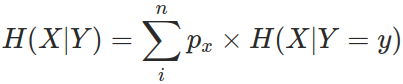
Px es la probabilidad relativa de aparición de la propiedad x en el conjunto de los datos en los que Y=y y H(X|Y=y) es la entropía de la propiedad y en el conjunto de los datos en los que Y=y.

In [57]:
def calcularEntropiaCondicionada(df,target,condicion):
    entropiaCondicionada = 0
    cols=df.columns.tolist()
    for valor in df[cols[condicion]].unique():
        p = df[cols[condicion]].value_counts()[valor] / len(df[cols[condicion]])
        counts = df[df[cols[condicion]] == valor][cols[target]].value_counts()
        entropia = sum([-count/counts.sum() * np.log2(count/counts.sum()) for count in counts])
        entropiaCondicionada += p * entropia
    return entropiaCondicionada

In [58]:
entropiaCondicionadaClass=calcularEntropiaCondicionada(df,3,0)
entropiaCondicionadaSex=calcularEntropiaCondicionada(df,3,1)
entropiaCondicionadaAge=calcularEntropiaCondicionada(df,3,2)
print('entropiaCondicionada(Survived,Class)=',entropiaCondicionadaClass)
print('entropiaCondicionada(Survived,Sex)=',entropiaCondicionadaSex)
print('entropiaCondicionada(Survived,Age)=',entropiaCondicionadaAge)

entropiaCondicionada(Survived,Class)= 0.8483634692722222
entropiaCondicionada(Survived,Sex)= 0.7652602113304224
entropiaCondicionada(Survived,Age)= 0.9012406875470709


### 3.4. Ganancia de Informacion

La ganancia de información muestra cómo se reduce la entropía cuando se añade una nueva variable. Una mayor reducción implica una correlación mayor con la variable explicada.
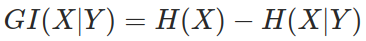

In [59]:
def obtenerGananciaDeInformacion(df,target,condicional):
    ganancia=calcularEntropia(df,target)-calcularEntropiaCondicionada(df,target,condicional)
    return ganancia

In [60]:
gi00=obtenerGananciaDeInformacion(df,3,0)
gi01=obtenerGananciaDeInformacion(df,3,1)
gi02=obtenerGananciaDeInformacion(df,3,2)
print('GI(Survived,Class)=',gi00)
print('GI(Survived,Sex)=',gi01)
print('GI(Survived,Age)=',gi02)

GI(Survived,Class)= 0.0592879366074337
GI(Survived,Sex)= 0.14239119454923344
GI(Survived,Age)= 0.006410718332584997


## 4. Armado del Ranking de aporte de Ganancia de Información

A partir del conjunto de datos, una vez definido el conjunto de variables independientes y variables objetivos, se presenta un ranking ordenado decrecientemente de las variables independientes en función de la ganancia de la información de la variable objetivo.

In [61]:
# Definiciones:
# - Dataset()
data=df.copy()
# - Variables
vars_indep=['0','1','2']
vars_target=['3']

In [62]:
def armarRankings(df, vars_indep, vars_target):
    nombreVars=data.columns.tolist()
    for i in range(len(vars_target)):
        # Dataframe:
        gi=pd.DataFrame()
        target=int(vars_target[i])
        entropia=calcularEntropia(data,target)
        print('Ganancia de Información de la variable ',str(nombreVars[target]))
        var_id=[]
        var_nom=[]
        var_gi=[]
        list_entropia=[]
        for j in range(len(vars_indep)):
            var=int(vars_indep[j])
            var_id.append(j)
            var_nom.append(nombreVars[j])
            var_gi.append(obtenerGananciaDeInformacion(data,target,j))
            list_entropia.append(entropia)
        gi['id']=var_id
        gi['nombre']=var_nom 
        gi['Ganancia']=var_gi
        gi['entropia global']=list_entropia
        gi_sorted=gi.sort_values(by=["Ganancia"],ascending=False)
        nombreFile=str(nombreVars[target])+".csv"
        #gi_sorted.to_csv(nombreFile,index = False)       
        print(gi_sorted)
armarRankings(data,vars_indep,vars_target)

Ganancia de Información de la variable  Survived
   id nombre  Ganancia  entropia global
1   1    Sex  0.142391         0.907651
0   0  Class  0.059288         0.907651
2   2    Age  0.006411         0.907651
